# Eğitime Hazırlık


In [ ]:
#Gerekli kütüphaneler
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
import re
import string

In [ ]:
#dataset okuma
data = pd.read_csv('/content/TweetsText.csv')

In [ ]:
#datasetteki ilk 5 verinin görünümü
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
#neutral olan kısımların göz ardı edilerek listelenmesi
data=data[data['airline_sentiment']!='neutral']
data.head()

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [ ]:
#dataset verilerinin temizlenmesi
def clean_tweet(text):
    tweet = ''
    tweet = re.sub('['+string.punctuation+']', '', text)
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', text)
    return tweet

In [ ]:
#temizlenen verilerin datasete uygulanması
data['text'] = data['text'].apply(lambda x: clean_tweet(x))

In [ ]:
#temizleme işlemlerinden sonra datasetin içindeki ilk 5 veri
data.head()

,text,airline_sentiment
0,What said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative


In [ ]:
#negatif ve pozitif verilerin boyutu
print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)
print(data[ data['airline_sentiment'] == 'neutral'].size)

#dataset içindeki tüm verilerde bulunan 'rt' nin boşluk ile değiştirilmesi
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt','')
data.head()

4726
18356
0


,text,airline_sentiment
1,plus you've added commercials to the experien...,positive
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
5,seriously would pay $30 a flight for seats th...,negative
6,"yes, nearly every time I fly VX this “ear wor...",positive


# Model Eğitim Aşaması

In [ ]:
#max özellik sayısı 2000 olarak ayarlandı
max_fatures = 5000
#metni vektörleştirmek ve dizilere dönüşütürmek için Tokenizer kullanıldı. Boşluğa göre cümleler ayrıldı.
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#kelime indexi oluşturuldu. text kolonundaki her cümlenin kelimesi ayrı ayrı indexlendi.
tokenizer.fit_on_texts(data['text'].values)
#texts_to_sequence ile kelimeler tam sayı dizilerine dönüştürüldü.
X = tokenizer.texts_to_sequences(data['text'].values)
#listedeki tüm dizilerin aynı uzunluğa sahip olması sağlandı.
X = pad_sequences(X)
#elde edilen diziden bir örnek.
X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  568,  524, 1280, 2380,    1,    2,  171],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   83,  117, 3211,    1,
        4020, 4021,  953,   12,   15, 4022,   53,   51,   20,  477, 2381]],
      dtype=int32)

In [ ]:
#Lstm model eğitim hiperparametreleri, değerler iyi sonuç elde etmek için değişkenlik gösterebilir.
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Aktivasyon yöntemi olarak softmax kullanıldı. Çünkü ağ kategorik çapraz entropi kullanmaktadır.
model.add(Dense(2,activation='softmax'))
#Metrics olarak Accuracy baz alındı.
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#Model özeti
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 128)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 33, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 895,194
Trainable params: 895,194
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Kategoriler 0 ve 1 haline dönüştürüldü.
Y = pd.get_dummies(data['airline_sentiment']).values
#Veriler eğitim ve test olmak üzere ayrıldı.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
#Eğitim içi ayrılan bölüm
print(X_train.shape,Y_train.shape)
#Test için ayrılan bölüm
print(X_test.shape,Y_test.shape)
print(Y)

(9232, 33) (9232, 2)
(2309, 33) (2309, 2)
[[0 1]
 [1 0]
 [1 0]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
batch_size = 128
history=model.fit(X_train, Y_train, validation_split=0.2, epochs = 50, batch_size=batch_size, verbose = 1,callbacks=[es,mc])

Epoch 1/50
58/58 [==============================] - 30s 461ms/step - loss: 0.5353 - accuracy: 0.7789 - val_loss: 0.3604 - val_accuracy: 0.8403

Epoch 00001: val_accuracy improved from -inf to 0.84028, saving model to best_model.h5
Epoch 2/50
58/58 [==============================] - 26s 451ms/step - loss: 0.2872 - accuracy: 0.8793 - val_loss: 0.2590 - val_accuracy: 0.8944

Epoch 00002: val_accuracy improved from 0.84028 to 0.89442, saving model to best_model.h5
Epoch 3/50
58/58 [==============================] - 27s 457ms/step - loss: 0.1611 - accuracy: 0.9423 - val_loss: 0.2295 - val_accuracy: 0.9025

Epoch 00003: val_accuracy improved from 0.89442 to 0.90254, saving model to best_model.h5
Epoch 4/50
58/58 [==============================] - 26s 449ms/step - loss: 0.1148 - accuracy: 0.9603 - val_loss: 0.2883 - val_accuracy: 0.9031

Epoch 00004: val_accuracy improved from 0.90254 to 0.90309, saving model to best_model.h5
Epoch 5/50
58/58 [==============================] - 26s 446ms/step 

In [ ]:
from keras.models import load_model
# load the saved model
saved_model = load_model('best_model.h5')

In [ ]:
_, train_acc = saved_model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.966, Test: 0.923


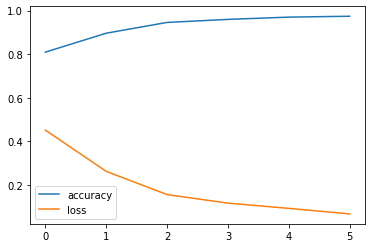

In [ ]:
#Model eğitim sonucunda oluşan accuracy ve loss grafiği
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

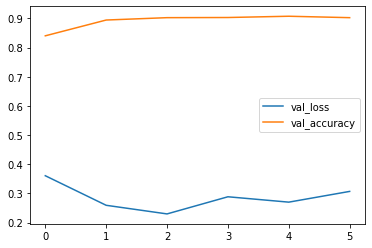

In [ ]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
#Tahmin yaparken pozitif veya negatif olma durumunu net bir şekilde göstermesi için predict_classes kullanıldı. 
Y_pred = model.predict_classes(X_test,batch_size = batch_size,)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score,precision_score,recall_score,log_loss
#Dataframe'de gerçek değer(true) ve tahmin edilen değerler(pred) ayarlandı. 
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
#Model eğitim sonucunda oluşan confusion matrix değerleri konsola yazdırıldı.
print("confusion matrix:\n",confusion_matrix(df_test.true, df_test.pred))
#Son olarak Classification raporu konsola yazdırıldı.
print("Classification_Report:\n",classification_report(df_test.true, df_test.pred))

confusion matrix:
 [[1814   48]
 [ 115  332]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1862
           1       0.87      0.74      0.80       447

    accuracy                           0.93      2309
   macro avg       0.91      0.86      0.88      2309
weighted avg       0.93      0.93      0.93      2309



In [ ]:
#Accuracy Score konsola yazdırıldı
print("Accuracy_Score:",accuracy_score(df_test.true,df_test.pred))
#F1-Score konsola yazdırıldı.
print("F1-Score(macro):",f1_score(df_test.true,df_test.pred,average='macro'))
print("F1-Score(weighted):",f1_score(df_test.true,df_test.pred,average='weighted'))


Accuracy_Score: 0.9294066695539195
F1-Score(macro): 0.8799527423985465
F1-Score(weighted): 0.9271708982182851


# TEST AŞAMASI

In [ ]:
tweet = ['I am not happy']
tweet = tokenizer.texts_to_sequences(tweet)
tweet

[[3, 100, 18, 349]]

In [ ]:
tweet = pad_sequences(tweet, maxlen=29, dtype='int32', value=0)
print(tweet)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   3 100  18 349]]


In [ ]:
#Duygu tahmini
sentiment = model.predict(tweet,batch_size=1,verbose = 1)
if (np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")
else:
  print("neutral")

1/1 [==============================] - 0s 24ms/step
negative


# Confuison Matrix Görselleştirme

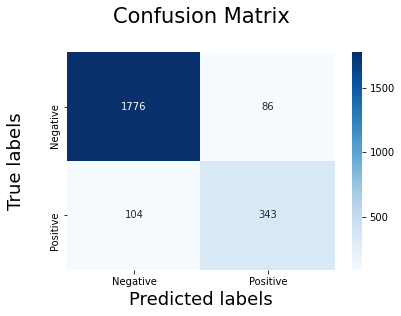

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(df_test.true, df_test.pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  
plt.rcParams.update({'font.size': 25})
label_font = {'size':'18'}  
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('True labels\n', fontdict=label_font);
title_font = {'size':'21'} 
ax.set_title('Confusion Matrix\n', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=10) 
ax.xaxis.set_ticklabels(['Negative', 'Positive']);
ax.yaxis.set_ticklabels(['Negative', 'Positive']);
plt.show()